# Step 0: Installation


In [ ]:
# Install required libraries
!pip install tab_transformer_pytorch
!pip install pytorch_tabnet
!pip install shap
!pip install imblearn
!pip install scikit-learn
!mkdir -p results  # Create directory for saving results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

# Step 1: Preliminary Setup


Using device: cuda
Loading and exploring dataset...

Dataset shape: (136136, 95)
Number of missing values: 0

Target variable distribution:
Preg_Complication
1    103092
0     33044
Name: count, dtype: int64
Target variable percentage:
Preg_Complication
1    75.727214
0    24.272786
Name: count, dtype: float64


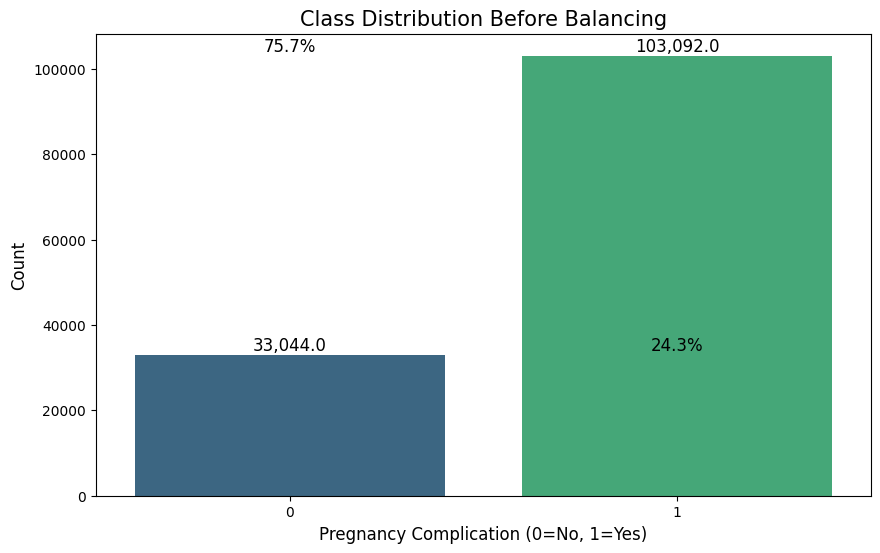


After cleaning:
Features shape: (136136, 93)
Number of features: 93

Missing values after imputation: 0
Features standardized successfully

PERFORMING LASSO FEATURE SELECTION
Training LASSO model with cross-validation...
Optimal alpha value: 0.001340

Number of features selected by LASSO: 67 out of 93

Top 20 most important features selected by LASSO:
1. Prenatal_care             0.1472
2. Preg_intParaDrug          0.0355
3. Resp_healthChk            0.0309
4. IronPill                  0.0161
5. Benefit_HCare             0.0160
6. PostnatalChk              0.0144
7. ultrasound                0.0112
8. HealthInsurance           0.0110
9. LastChild_Want            0.0107
10. DeliveryPlace_Private     -0.0105
11. Religion_Sikh             0.0101
12. Ethnicity_No caste / tribe 0.0098
13. VitaminA                  0.0095
14. DPT_full                  -0.0090
15. Antenatal_visits          0.0087
16. ChildGiven_otherBMilk     -0.0082
17. Alcohol                   0.0082
18. Water_Source_Othe

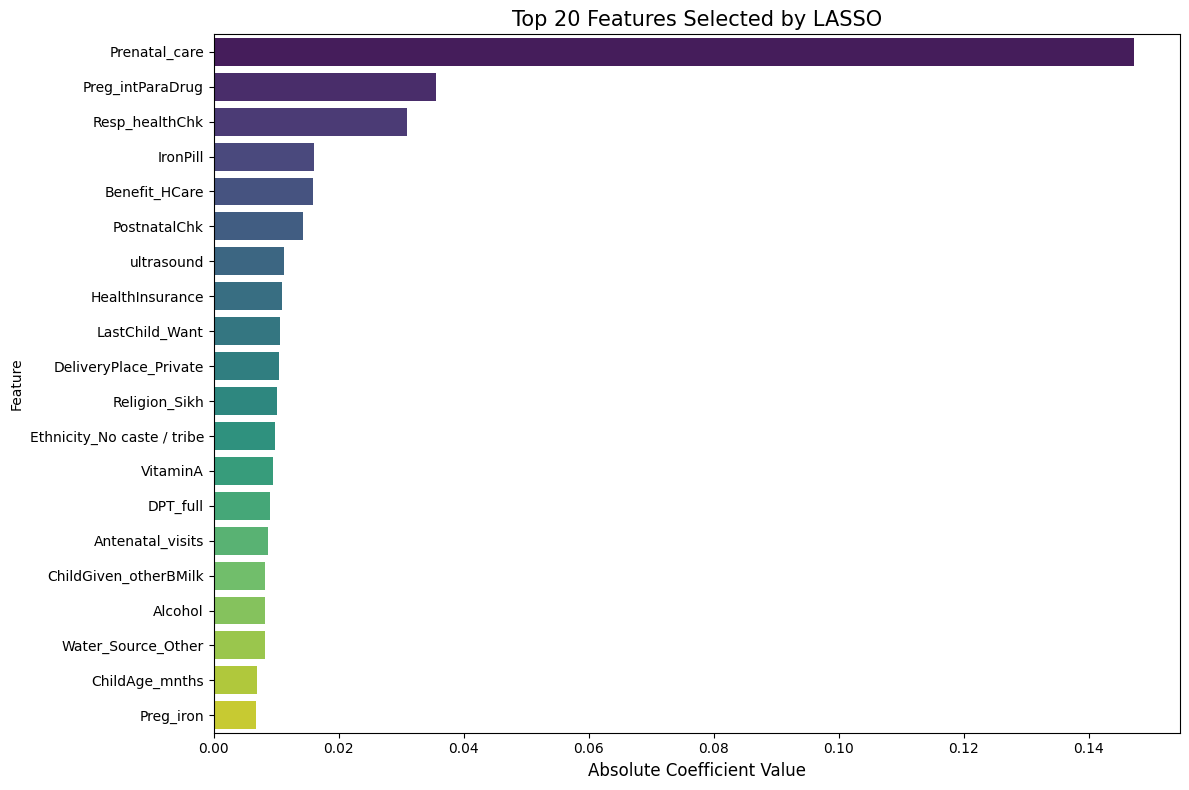


Selected features data shape: (136136, 67)
Selected feature names saved to 'results/feature_names.npy'
Class distribution before balancing:
Preg_Complication
1    103092
0     33044
Name: count, dtype: int64
Class ratio before balancing: 1:0.32


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ML Tools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tab_transformer_pytorch import TabTransformer, FTTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

# Class Balancing
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

import gc
import os
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
print("Loading and exploring dataset...")
df = pd.read_csv('/content/Final.csv')

print(f"\nDataset shape: {df.shape}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

target_counts = df['Preg_Complication'].value_counts()
print(f"\nTarget variable distribution:\n{target_counts}")
print(f"Target variable percentage:\n{target_counts / len(df) * 100}")

# Class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Preg_Complication', data=df, palette='viridis')
plt.title('Class Distribution Before Balancing', fontsize=15)
plt.xlabel('Pregnancy Complication (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Add percentage labels
for i, count in enumerate(target_counts):
    percentage = count / len(df) * 100
    ax.text(i, count + 1000, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.show()

# Cleaning the dataset
df = df.dropna(axis=1, how='all').drop_duplicates()
df = df.select_dtypes(include=[np.number])  # Keep numeric columns only

# Separate features and target
X = df.drop(columns=['Preg_Complication'], errors='ignore')
y = df['Preg_Complication']

print(f"\nAfter cleaning:")
print(f"Features shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Fill missing values with median
X = X.fillna(X.median())
print("\nMissing values after imputation:", X.isnull().sum().sum())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized successfully")

# Feature Selection with LASSO
print("PERFORMING LASSO FEATURE SELECTION")

# Define LASSO model with cross-validation for optimal alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
print("Training LASSO model with cross-validation...")
lasso_cv.fit(X_scaled, y)

print(f"Optimal alpha value: {lasso_cv.alpha_:.6f}")

# Get non-zero coefficients (selected features)
selected_features_mask = lasso_cv.coef_ != 0
selected_features = np.where(selected_features_mask)[0]
selected_feature_names = X.columns[selected_features].tolist()

print(f"\nNumber of features selected by LASSO: {len(selected_features)} out of {X.shape[1]}")

# Create a DataFrame with feature names and their coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X.columns[selected_features],
    'Coefficient': lasso_cv.coef_[selected_features]
})

# Sort by absolute coefficient value
feature_importance_df['AbsCoefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values('AbsCoefficient', ascending=False)

# Display top 20 features
print("\nTop 20 most important features selected by LASSO:")
for i, (feature, coef) in enumerate(zip(feature_importance_df['Feature'][:20],
                                        feature_importance_df['Coefficient'][:20])):
    print(f"{i+1}. {feature:<25} {coef:.4f}")

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(x='AbsCoefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Features Selected by LASSO', fontsize=15)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()

# Get the selected features from the scaled data
X_selected = X_scaled[:, selected_features]
print(f"\nSelected features data shape: {X_selected.shape}")

# Save selected feature names for later use
np.save('results/feature_names.npy', selected_feature_names)
print("Selected feature names saved to 'results/feature_names.npy'")

# Define all balancing techniques to compare
balancing_techniques = {
    'No Balancing': None,  # Will be handled specially
    'Random Oversampling': RandomOverSampler(random_state=42),
    'Random Undersampling': RandomUnderSampler(random_state=42),
    'SMOTE Only': SMOTE(random_state=42),
    'NearMiss Only': NearMiss(version=1, n_neighbors=3),
    'ADASYN': ADASYN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
}

# Create a dictionary to store results for each technique
balancing_results = {}

# Display original class distribution for reference
print("Class distribution before balancing:")
print(pd.Series(y).value_counts())
print(f"Class ratio before balancing: 1:{pd.Series(y).value_counts()[0]/pd.Series(y).value_counts()[1]:.2f}")

# Step 2: Evaluation Function

In [ ]:
# Function to identify categorical features
def identify_categorical_features(X, feature_names, threshold=15):
    """
    Identify categorical features based on the number of unique values.
    If a feature has <= threshold unique values, it's likely categorical.
    """
    cat_indices = []
    cat_names = []
    num_indices = []
    num_names = []

    for i, name in enumerate(feature_names):
        # Count unique values
        unique_vals = np.unique(X[:, i])
        n_unique = len(unique_vals)

        # If there are few unique values and they are integers, treat as categorical
        if n_unique <= threshold and np.issubdtype(unique_vals.dtype, np.integer):
            cat_indices.append(i)
            cat_names.append(name)
        else:
            num_indices.append(i)
            num_names.append(name)

    return cat_indices, cat_names, num_indices, num_names

# Function to split data into categorical and numerical arrays
def split_cat_num(X, cat_cols, num_cols):
    if len(cat_cols) > 0:
        X_cat = X[:, cat_cols].astype(np.int64)  # Categorical features
    else:
        X_cat = np.zeros((X.shape[0], 1), dtype=np.int64)

    if len(num_cols) > 0:
        X_num = X[:, num_cols].astype(np.float32)  # Numerical features
    else:
        X_num = np.zeros((X.shape[0], 1), dtype=np.float32) 

    return X_cat, X_num

# Function to get cardinalities for categorical features
def get_cat_cardinalities(X_cat):
    cardinals = []
    for col_idx in range(X_cat.shape[1]):
        unique_vals = np.unique(X_cat[:, col_idx])
        cardinals.append(len(unique_vals))
    return tuple(cardinals)

# Training function for TabTransformer and FT-Transformer
def train_tabular_model(model, X_cat, X_num, y, X_cat_val, X_num_val, y_val,
                       epochs=15, batch_size=256, lr=1e-3):
    """
    Train a tabular transformer model (TabTransformer or FT-Transformer).
    """
    # Convert pandas Series to numpy array
    if hasattr(y, 'values'):
        y = y.values
    if hasattr(y_val, 'values'):
        y_val = y_val.values

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32).view(-1, 1)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_cat_val_t = torch.tensor(X_cat_val, dtype=torch.long).to(device)
    X_num_val_t = torch.tensor(X_num_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_correct, total_samples = 0, 0

        for cat_b, num_b, y_b in loader:
            cat_b = cat_b.to(device)
            num_b = num_b.to(device)
            y_b = y_b.to(device)

            optimizer.zero_grad()
            logits = model(cat_b, num_b)
            loss = criterion(logits, y_b)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            total_correct += (preds == y_b).sum().item()
            total_samples += y_b.size(0)

        avg_loss = total_loss / len(loader)
        train_acc = total_correct / total_samples

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_logits = model(X_cat_val_t, X_num_val_t)
            val_loss = criterion(val_logits, y_val_t).item()
            val_preds = (torch.sigmoid(val_logits) > 0.5).float()
            val_correct = (val_preds == y_val_t).sum().item()
            val_acc = val_correct / y_val_t.size(0)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

# Prediction functions
def predict_tabular_model(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        cat_t = torch.tensor(X_cat, dtype=torch.long).to(device)
        num_t = torch.tensor(X_num, dtype=torch.float32).to(device)
        logits = model(cat_t, num_t).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# Main evaluation function 
def evaluate_balancing_technique(X_selected, y, technique_name, balancing_technique=None):
    print(f"EVALUATING: {technique_name}")

    # Apply the balancing technique (if any)
    if balancing_technique is None:
        print("Using original imbalanced data (no balancing)")
        X_balanced = X_selected.copy()
        y_balanced = y.copy()
    else:
        print(f"Applying {technique_name}...")
        X_balanced, y_balanced = balancing_technique.fit_resample(X_selected, y)

    # Display class distribution after balancing
    balanced_counts = pd.Series(y_balanced).value_counts()
    print(f"\nClass distribution after {technique_name}:")
    print(balanced_counts)
    print(f"Class ratio after balancing: 1:{balanced_counts[0]/balanced_counts[1]:.2f}")

    # Split the balanced data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    # Convert labels to the correct data type for PyTorch
    y_train_f = y_train.astype(np.float32)
    y_test_f = y_test.astype(np.float32)

    # Identify categorical and numerical features
    cat_cols, cat_feature_names, num_cols, num_feature_names = identify_categorical_features(
        X_train, selected_feature_names, threshold=15
    )

    # Split categorical and numerical features
    X_train_cat, X_train_num = split_cat_num(X_train, cat_cols, num_cols)
    X_test_cat, X_test_num = split_cat_num(X_test, cat_cols, num_cols)

    # For TabNet: combine both into a single array
    X_train_tabnet = np.concatenate([X_train_cat, X_train_num], axis=1).astype(np.float32)
    X_test_tabnet = np.concatenate([X_test_cat, X_test_num], axis=1).astype(np.float32)

    # Get cardinalities for categorical features
    cat_cardinalities = get_cat_cardinalities(X_train_cat)

    print(f"\nTraining models for {technique_name}...")
    print(f"- Categorical features: {len(cat_cardinalities)}")
    print(f"- Numerical features: {X_train_num.shape[1]}")

    # Initialize TabTransformer model
    model_tab = TabTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num.shape[1],
        dim=64, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1
    ).to(device)

    # Initialize FT-Transformer model
    model_ft = FTTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num.shape[1],
        dim=32, dim_out=1, depth=2, heads=2,
        attn_dropout=0.2, ff_dropout=0.2
    ).to(device)

    # Initialize TabNet model
    model_tabnet = TabNetClassifier(
        n_d=16, n_a=16, n_steps=4, gamma=1.3,
        cat_idxs=[], cat_dims=[], cat_emb_dim=1,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-3),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax'
    )

    # Train TabTransformer
    print("\nTraining TabTransformer...")
    _, _, _, tab_val_acc = train_tabular_model(
        model_tab, X_train_cat, X_train_num, y_train_f,
        X_test_cat, X_test_num, y_test_f,
        epochs=10, batch_size=256, lr=1e-3
    )

    # Clean up memory
    clear_memory = lambda: (gc.collect(), torch.cuda.empty_cache() if torch.cuda.is_available() else None)
    clear_memory()

    # Train FT-Transformer
    print("\nTraining FT-Transformer...")
    _, _, _, ft_val_acc = train_tabular_model(
        model_ft, X_train_cat, X_train_num, y_train_f,
        X_test_cat, X_test_num, y_test_f,
        epochs=15, batch_size=256, lr=1e-3
    )

    clear_memory()

    # Train TabNet
    print("\nTraining TabNet...")
    tabnet_success = False
    try:
        y_train_int = y_train.astype(np.int64)
        y_test_int = y_test.astype(np.int64)

        model_tabnet.fit(
            X_train_tabnet, y_train_int,
            eval_set=[(X_test_tabnet, y_test_int)],
            eval_name=['val'],
            eval_metric=['accuracy'],
            max_epochs=10,
            patience=5,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )
        tabnet_success = True
    except Exception as e:
        print(f"Error training TabNet: {e}")
        print("Will use average of other models for TabNet predictions")

    clear_memory()

    # Make predictions
    print("\nGenerating predictions...")

    # TabTransformer predictions
    tab_preds = predict_tabular_model(model_tab, X_test_cat, X_test_num)
    tab_binary_preds = (tab_preds > 0.5).astype(int)

    # FT-Transformer predictions
    ft_preds = predict_tabular_model(model_ft, X_test_cat, X_test_num)
    ft_binary_preds = (ft_preds > 0.5).astype(int)

    # TabNet predictions
    if tabnet_success:
        tn_preds = model_tabnet.predict_proba(X_test_tabnet)[:, 1]
    else:
        tn_preds = (tab_preds + ft_preds) / 2
    tn_binary_preds = (tn_preds > 0.5).astype(int)

    # Ensemble predictions
    ensemble_probs = (tab_preds + ft_preds + tn_preds) / 3
    ensemble_preds = (ensemble_probs > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, ensemble_preds),
        'precision': precision_score(y_test, ensemble_preds),
        'recall': recall_score(y_test, ensemble_preds),
        'f1_score': f1_score(y_test, ensemble_preds),
        'auc_roc': roc_auc_score(y_test, ensemble_probs)
    }

    print(f"\nEnsemble Model Performance for {technique_name}:")
    print(f"- Accuracy:  {metrics['accuracy']:.4f}")
    print(f"- Precision: {metrics['precision']:.4f}")
    print(f"- Recall:    {metrics['recall']:.4f}")
    print(f"- F1-Score:  {metrics['f1_score']:.4f}")
    print(f"- AUC-ROC:   {metrics['auc_roc']:.4f}")

    return {
        'technique': technique_name,
        'metrics': metrics,
        'X_balanced': X_balanced,
        'y_balanced': y_balanced
    }

#Step 3: Run experiments for each technique


COMPARING BALANCING TECHNIQUES

EVALUATING: No Balancing
Using original imbalanced data (no balancing)

Class distribution after No Balancing:
Preg_Complication
1    103092
0     33044
Name: count, dtype: int64
Class ratio after balancing: 1:0.32

Training models for No Balancing...
- Categorical features: 1
- Numerical features: 67

Training TabTransformer...

Epoch   Train Loss      Train Acc      Val Loss        Val Acc    
------------------------------------------------------------
  1       0.4771         0.7970         0.4729         0.7997     
  2       0.4596         0.8034         0.4668         0.8029     
  3       0.4568         0.8039         0.4566         0.8033     
  4       0.4537         0.8045         0.4594         0.8036     
  5       0.4503         0.8054         0.4586         0.8009     
  6       0.4476         0.8056         0.4554         0.8037     
  7       0.4439         0.8075         0.4551         0.8033     
  8       0.4397         0.8084       

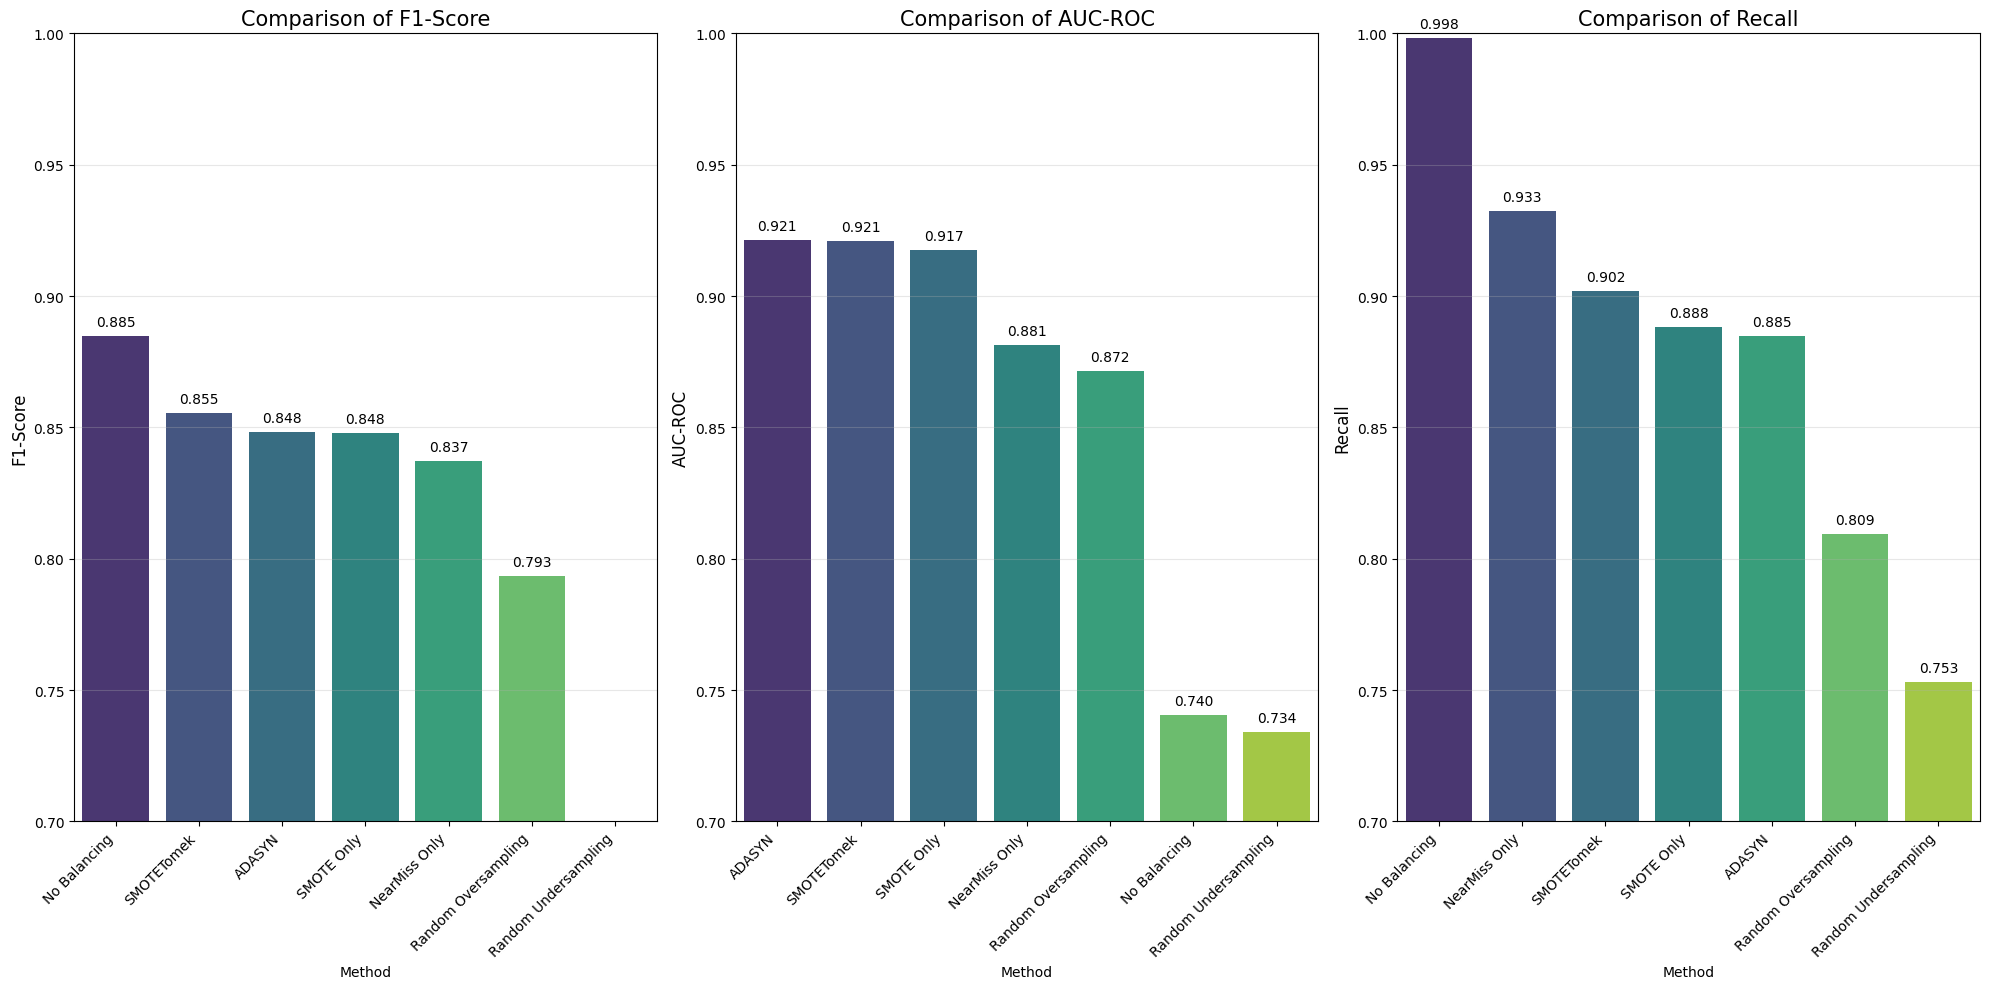


Best balancing technique based on F1-Score: No Balancing
Best balanced data saved to 'results/' folder


In [ ]:
# Step 3: Run experiment for each technique
print("COMPARING BALANCING TECHNIQUES")

# Modify training function to show all metrics for each epoch
def train_tabular_model_verbose(model, X_cat, X_num, y, X_cat_val, X_num_val, y_val,
                       epochs=15, batch_size=256, lr=1e-3):
    """
    Train a tabular transformer model with verbose output for each epoch.
    """
    # Convert pandas Series to numpy array
    if hasattr(y, 'values'):
        y = y.values
    if hasattr(y_val, 'values'):
        y_val = y_val.values

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32).view(-1, 1)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_cat_val_t = torch.tensor(X_cat_val, dtype=torch.long).to(device)
    X_num_val_t = torch.tensor(X_num_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Print training progress
    print(f"\n{'Epoch':^6}{'Train Loss':^15}{'Train Acc':^15}{'Val Loss':^15}{'Val Acc':^15}")
    print(f"{'-'*60}")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_correct, total_samples = 0, 0

        for cat_b, num_b, y_b in loader:
            cat_b = cat_b.to(device)
            num_b = num_b.to(device)
            y_b = y_b.to(device)

            optimizer.zero_grad()
            logits = model(cat_b, num_b)
            loss = criterion(logits, y_b)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            total_correct += (preds == y_b).sum().item()
            total_samples += y_b.size(0)

        avg_loss = total_loss / len(loader)
        train_acc = total_correct / total_samples

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_logits = model(X_cat_val_t, X_num_val_t)
            val_loss = criterion(val_logits, y_val_t).item()
            val_preds = (torch.sigmoid(val_logits) > 0.5).float()
            val_correct = (val_preds == y_val_t).sum().item()
            val_acc = val_correct / y_val_t.size(0)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress for this epoch
        print(f"{epoch+1:^6}{avg_loss:^15.4f}{train_acc:^15.4f}{val_loss:^15.4f}{val_acc:^15.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Updated evaluation function with verbose training
def evaluate_balancing_technique_verbose(X_selected, y, technique_name, balancing_technique=None):
    print(f"EVALUATING: {technique_name}")

    # balancing technique
    if balancing_technique is None:
        print("Using original imbalanced data (no balancing)")
        X_balanced = X_selected.copy()
        y_balanced = y.copy()
    else:
        print(f"Applying {technique_name}...")
        X_balanced, y_balanced = balancing_technique.fit_resample(X_selected, y)

    # Display class distribution
    balanced_counts = pd.Series(y_balanced).value_counts()
    print(f"\nClass distribution after {technique_name}:")
    print(balanced_counts)
    print(f"Class ratio after balancing: 1:{balanced_counts[0]/balanced_counts[1]:.2f}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    # Convert labels
    y_train_f = y_train.astype(np.float32)
    y_test_f = y_test.astype(np.float32)

    # Identify features
    cat_cols, cat_feature_names, num_cols, num_feature_names = identify_categorical_features(
        X_train, selected_feature_names, threshold=15
    )

    # Split features
    X_train_cat, X_train_num = split_cat_num(X_train, cat_cols, num_cols)
    X_test_cat, X_test_num = split_cat_num(X_test, cat_cols, num_cols)

    # For TabNet: combine both into a single array
    X_train_tabnet = np.concatenate([X_train_cat, X_train_num], axis=1).astype(np.float32)
    X_test_tabnet = np.concatenate([X_test_cat, X_test_num], axis=1).astype(np.float32)

    cat_cardinalities = get_cat_cardinalities(X_train_cat)

    print(f"\nTraining models for {technique_name}...")
    print(f"- Categorical features: {len(cat_cardinalities)}")
    print(f"- Numerical features: {X_train_num.shape[1]}")

    # Initialize TabTransformer model
    model_tab = TabTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num.shape[1],
        dim=64, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1
    ).to(device)

    # Initialize FT-Transformer model
    model_ft = FTTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num.shape[1],
        dim=32, dim_out=1, depth=2, heads=2,
        attn_dropout=0.2, ff_dropout=0.2
    ).to(device)

    # Initialize TabNet model
    model_tabnet = TabNetClassifier(
        n_d=16, n_a=16, n_steps=4, gamma=1.3,
        cat_idxs=[], cat_dims=[], cat_emb_dim=1,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-3),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax'
    )

    # Train TabTransformer 
    print("\nTraining TabTransformer...")
    tab_train_loss, tab_val_loss, tab_train_acc, tab_val_acc = train_tabular_model_verbose(
        model_tab, X_train_cat, X_train_num, y_train_f,
        X_test_cat, X_test_num, y_test_f,
        epochs=10, batch_size=256, lr=1e-3
    )

    # Clean up memory
    clear_memory = lambda: (gc.collect(), torch.cuda.empty_cache() if torch.cuda.is_available() else None)
    clear_memory()

    # Train FT-Transformer 
    print("\nTraining FT-Transformer...")
    ft_train_loss, ft_val_loss, ft_train_acc, ft_val_acc = train_tabular_model_verbose(
        model_ft, X_train_cat, X_train_num, y_train_f,
        X_test_cat, X_test_num, y_test_f,
        epochs=15, batch_size=256, lr=1e-3
    )

    clear_memory()

    # Train TabNet
    print("\nTraining TabNet...")
    tabnet_success = False
    try:
        y_train_int = y_train.astype(np.int64)
        y_test_int = y_test.astype(np.int64)

        model_tabnet.fit(
            X_train_tabnet, y_train_int,
            eval_set=[(X_test_tabnet, y_test_int)],
            eval_name=['val'],
            eval_metric=['accuracy'],
            max_epochs=10,
            patience=5,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0
        )
        tabnet_success = True
    except Exception as e:
        print(f"Error training TabNet: {e}")
        print("Will use average of other models for TabNet predictions")

    clear_memory()

    print("\nGenerating predictions...")

    # TabTransformer predictions
    tab_preds = predict_tabular_model(model_tab, X_test_cat, X_test_num)
    tab_binary_preds = (tab_preds > 0.5).astype(int)

    # FT-Transformer predictions
    ft_preds = predict_tabular_model(model_ft, X_test_cat, X_test_num)
    ft_binary_preds = (ft_preds > 0.5).astype(int)

    # TabNet predictions
    if tabnet_success:
        tn_preds = model_tabnet.predict_proba(X_test_tabnet)[:, 1]
    else:
        tn_preds = (tab_preds + ft_preds) / 2
    tn_binary_preds = (tn_preds > 0.5).astype(int)

    # Ensemble predictions
    ensemble_probs = (tab_preds + ft_preds + tn_preds) / 3
    ensemble_preds = (ensemble_probs > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, ensemble_preds),
        'precision': precision_score(y_test, ensemble_preds),
        'recall': recall_score(y_test, ensemble_preds),
        'f1_score': f1_score(y_test, ensemble_preds),
        'auc_roc': roc_auc_score(y_test, ensemble_probs)
    }

    print(f"\nEnsemble Model Performance for {technique_name}:")
    print(f"- Accuracy:  {metrics['accuracy']:.4f}")
    print(f"- Precision: {metrics['precision']:.4f}")
    print(f"- Recall:    {metrics['recall']:.4f}")
    print(f"- F1-Score:  {metrics['f1_score']:.4f}")
    print(f"- AUC-ROC:   {metrics['auc_roc']:.4f}")

    return {
        'technique': technique_name,
        'metrics': metrics,
        'X_balanced': X_balanced,
        'y_balanced': y_balanced,
        'training_history': {
            'tab_transformer': {
                'train_loss': tab_train_loss,
                'val_loss': tab_val_loss,
                'train_acc': tab_train_acc,
                'val_acc': tab_val_acc
            },
            'ft_transformer': {
                'train_loss': ft_train_loss,
                'val_loss': ft_val_loss,
                'train_acc': ft_train_acc,
                'val_acc': ft_val_acc
            }
        }
    }

all_results = {}

# Run evaluation for each balancing technique
for technique_name, balancing_technique in balancing_techniques.items():
    # Run the full modeling pipeline with this balancing technique using verbose version
    results = evaluate_balancing_technique_verbose(X_selected, y, technique_name, balancing_technique)

    all_results[technique_name] = results

# Create a summary dataframe for comparison
comparison_df = pd.DataFrame([
    {
        'Method': technique,
        'F1-Score': results['metrics']['f1_score'],
        'AUC-ROC': results['metrics']['auc_roc'],
        'Recall': results['metrics']['recall'],
        'Precision': results['metrics']['precision'],
        'Accuracy': results['metrics']['accuracy']
    }
    for technique, results in all_results.items()
])

# Sort by F1-Score (descending)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

# Display comparison table
print("\n" + "="*50)
print("BALANCING TECHNIQUES COMPARISON RESULTS")
print("="*50)
print(comparison_df)

# Save comparison table to CSV
comparison_df.to_csv('results/balancing_comparison.csv', index=False)
print("\nComparison table saved to 'results/balancing_comparison.csv'")

# Create visualizations for metrics comparison
plt.figure(figsize=(20, 10))

# Plot F1-Score, AUC-ROC, and Recall
metrics = ['F1-Score', 'AUC-ROC', 'Recall']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)

    # Sort by current metric for this specific plot
    sorted_df = comparison_df.sort_values(metric, ascending=False)

    # Create bar plot
    ax = sns.barplot(x='Method', y=metric, data=sorted_df, palette='viridis')

    plt.title(f'Comparison of {metric}', fontsize=15)
    plt.ylabel(metric, fontsize=12)
    plt.ylim(0.7, 1.0)  # Set y-axis range for better comparison
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Add value labels on top of bars
    for j, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.3f}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha = 'center', va = 'bottom',
                   xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.savefig('results/balancing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best technique based on F1-Score
best_technique = comparison_df.iloc[0]['Method']
print(f"\nBest balancing technique based on F1-Score: {best_technique}")

# Get the balanced data from the best technique for further modeling
best_X_balanced = all_results[best_technique]['X_balanced']
best_y_balanced = all_results[best_technique]['y_balanced']

# Save the best balanced data for further use
np.save('results/best_X_balanced.npy', best_X_balanced)
np.save('results/best_y_balanced.npy', best_y_balanced)
print(f"Best balanced data saved to 'results/' folder")